In [28]:
import pandas as pd
import shap

#shap.initjs()  # For interactive plots (works in Jupyter/Colab)

In [29]:
df = pd.read_csv("../data/dataproject2025_preprocessed.csv")
df.head()

,num__issue_d,num__loan duration,num__annual_inc,num__avg_cur_bal,num__bc_open_to_buy,num__bc_util,num__delinq_2yrs,num__dti,num__fico_range_high,num__funded_amnt,...,cat__sub_grade_F3,cat__sub_grade_F4,cat__sub_grade_F5,cat__sub_grade_G1,cat__sub_grade_G2,cat__sub_grade_G3,cat__sub_grade_G4,cat__sub_grade_G5,Predicted probabilities,target
0,-1.687635,-0.637761,-0.740512,-0.745082,0.749479,-1.586997,-0.370384,-1.880644,2.106130,-1.180039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053051,0
1,-1.687635,-0.637761,-0.470965,-0.250508,0.416937,-0.242629,-0.370384,0.530276,1.258044,1.180387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084507,0
2,-1.687635,-0.637761,4.254853,2.390279,0.248935,0.226833,-0.370384,0.019227,1.766896,1.281169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037206,0
3,-1.687635,-0.637761,0.841762,1.367198,-0.426078,1.147974,-0.370384,-0.633779,0.749193,-0.416216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061371,0
4,-1.687635,1.567986,-0.155910,0.630499,-0.342077,0.497129,0.729341,0.561034,-0.946979,1.238734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345896,1


In [30]:
X = df.drop(columns = ["target", "Predicted probabilities"])
y = df["target"]

# To be deleted:

In [31]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    verbose=0,        # no training logs
    random_seed=42,   # reproducibility
    eval_metric="Logloss"
)

model.fit(X, y)


In [32]:
import shap
#shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [34]:
# Choose observation
index_to_explain = 0
single_X = X.iloc[[index_to_explain]]

# Compute SHAP values
single_shap_values = explainer.shap_values(single_X)

# Local explanation (interactive plot in notebook)
shap.force_plot(explainer.expected_value, single_shap_values, single_X)


<Figure size 1200x300 with 0 Axes>

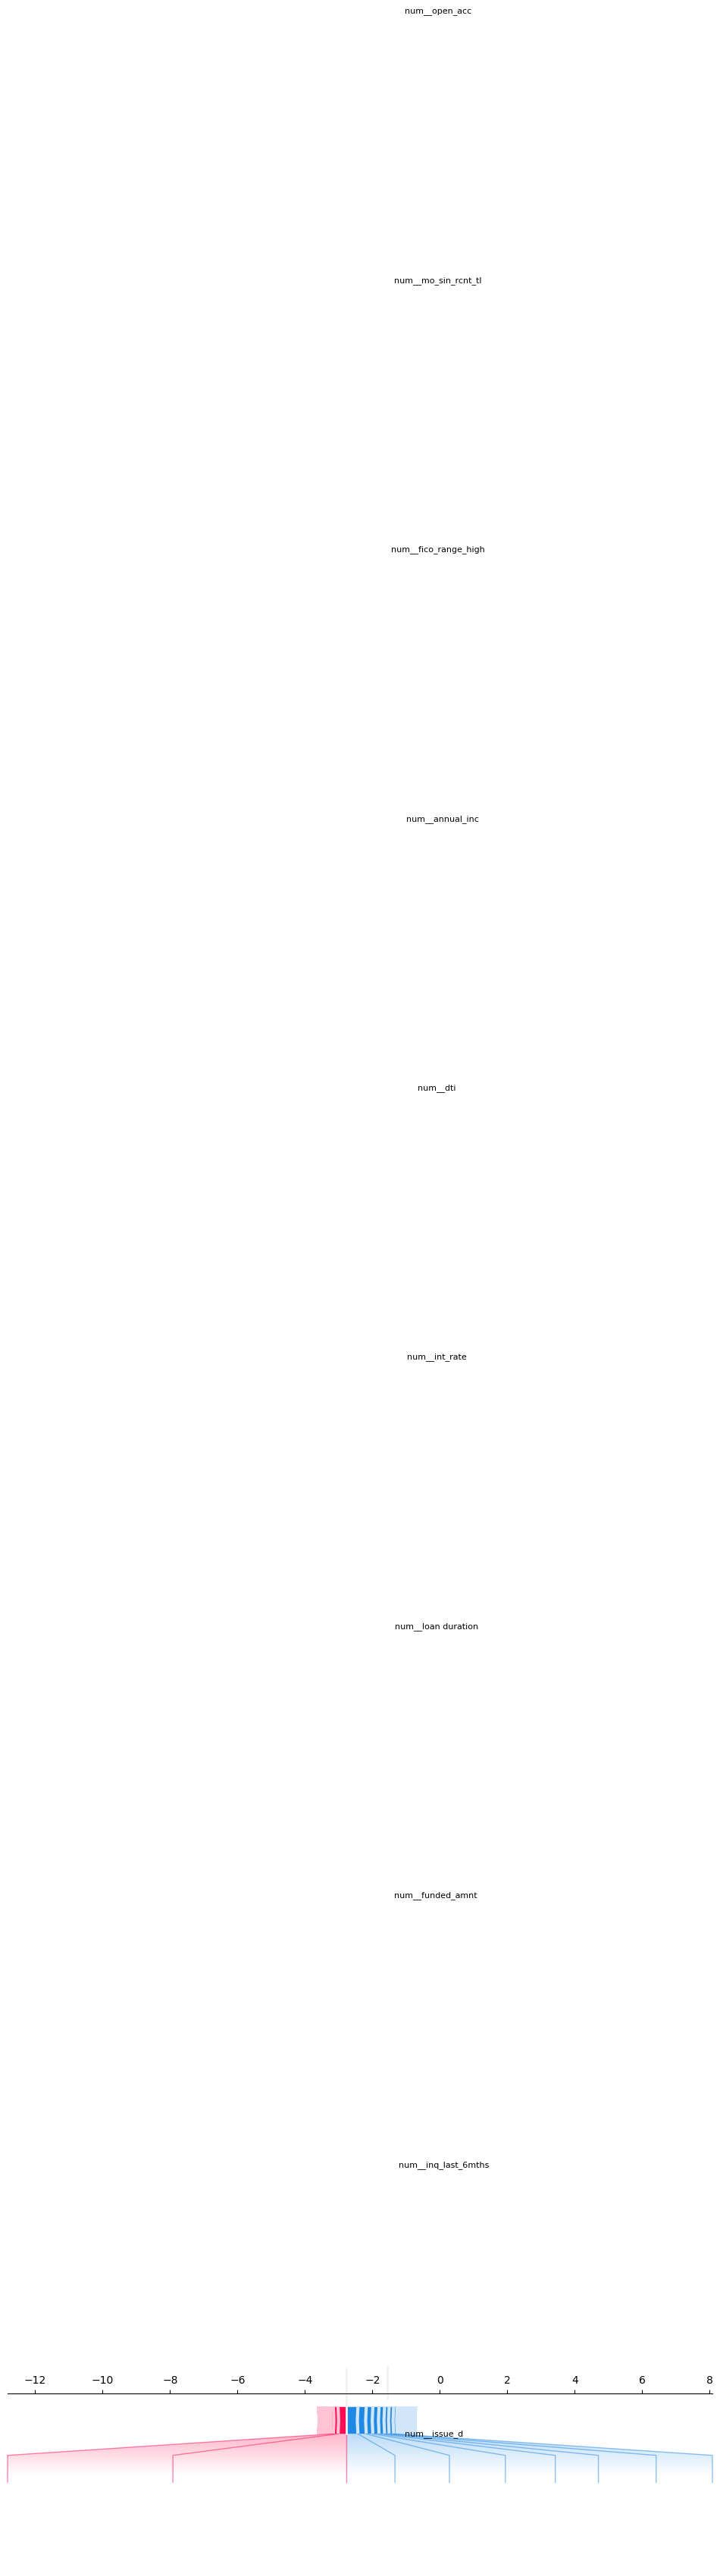

In [44]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Choose observation
index_to_explain = 0
single_X = X.iloc[[index_to_explain]]

# Compute SHAP values
single_shap_values = explainer.shap_values(single_X)

# Sort by absolute SHAP values (for labeling)
abs_shap_values = np.abs(single_shap_values[0])
sorted_idx = np.argsort(abs_shap_values)[::-1]

# Decide how many names to display
top_n_to_label = 10  # show names for top 10 features only
top_features_idx = sorted_idx[:top_n_to_label]

# Generate the force plot (matplotlib version)
fig = plt.figure(figsize=(12, 3))
shap.force_plot(
    explainer.expected_value,
    single_shap_values,
    single_X,
    matplotlib=True,
    show=False,       # Prevent immediate display
    figsize=(12, 3),
    text_rotation=0
)

# White background
plt.gca().set_facecolor("white")
plt.gcf().set_facecolor("white")

# Remove all text labels first
for text in plt.gca().texts:
    text.set_visible(False)

# Add back only top feature names
for i, idx in enumerate(top_features_idx):
    shap_val = single_shap_values[0][idx]
    feature_name = single_X.columns[idx]
    # Place label at half bar length
    plt.text(
        shap_val / 2, i, feature_name,
        ha="center", va="center", fontsize=8, color="black"
    )

plt.show()


findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


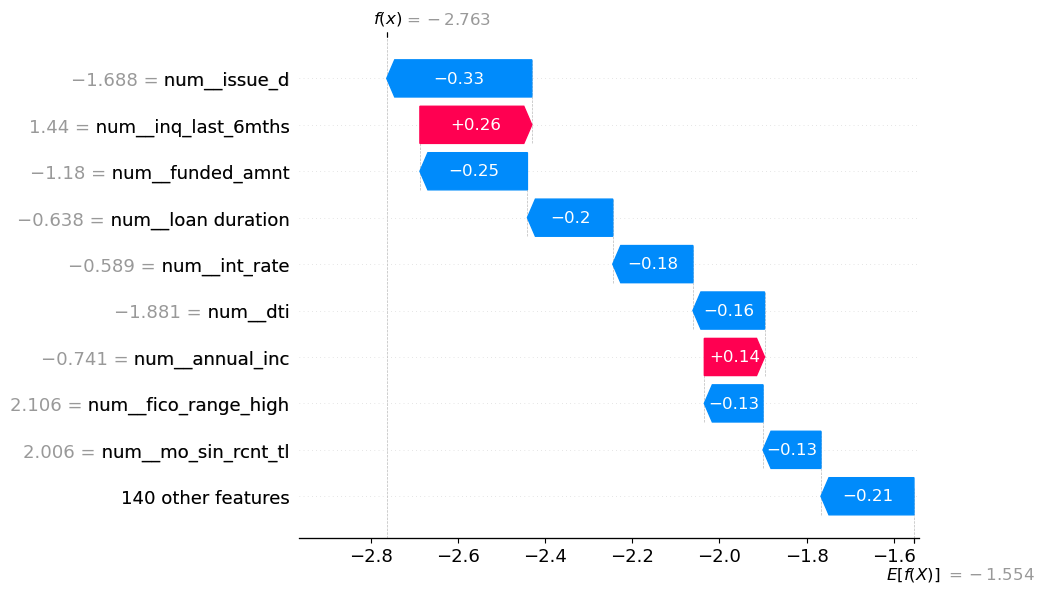

In [21]:
shap.plots.waterfall(
    shap.Explanation(
        values=single_shap_values[0],
        base_values=explainer.expected_value,
        data=single_X.values[0],
        feature_names=single_X.columns.tolist()
    )
)


In [23]:
from catboost import Pool

pool = Pool(data=X, label=y)


shap_values = model.get_feature_importance(
    data=pool,
    type="ShapValues"
)


In [24]:
import shap
shap.initjs()

# Choose one observation
index_to_explain = 0
single_X = X.iloc[[index_to_explain]]

# Extract SHAP values for this row
single_shap_values = shap_values[index_to_explain, :-1]
base_value = shap_values[index_to_explain, -1]

# Force plot
shap.force_plot(base_value, single_shap_values, single_X)


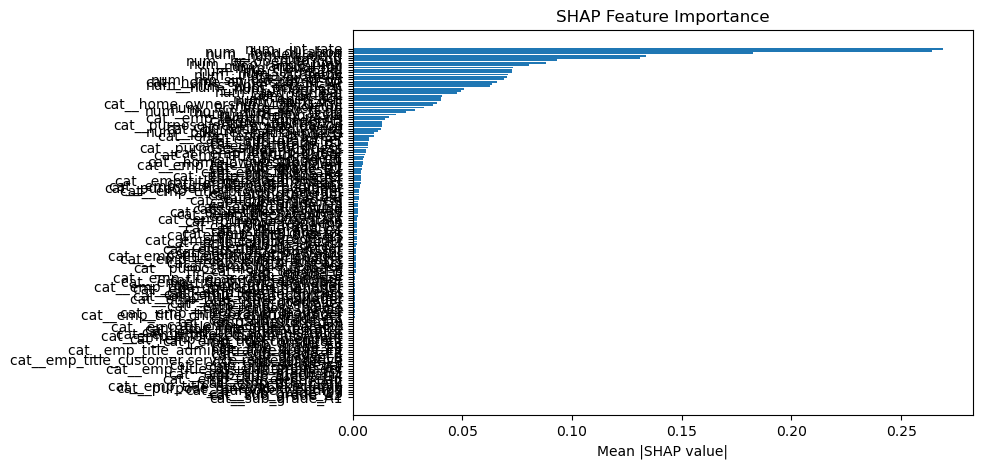

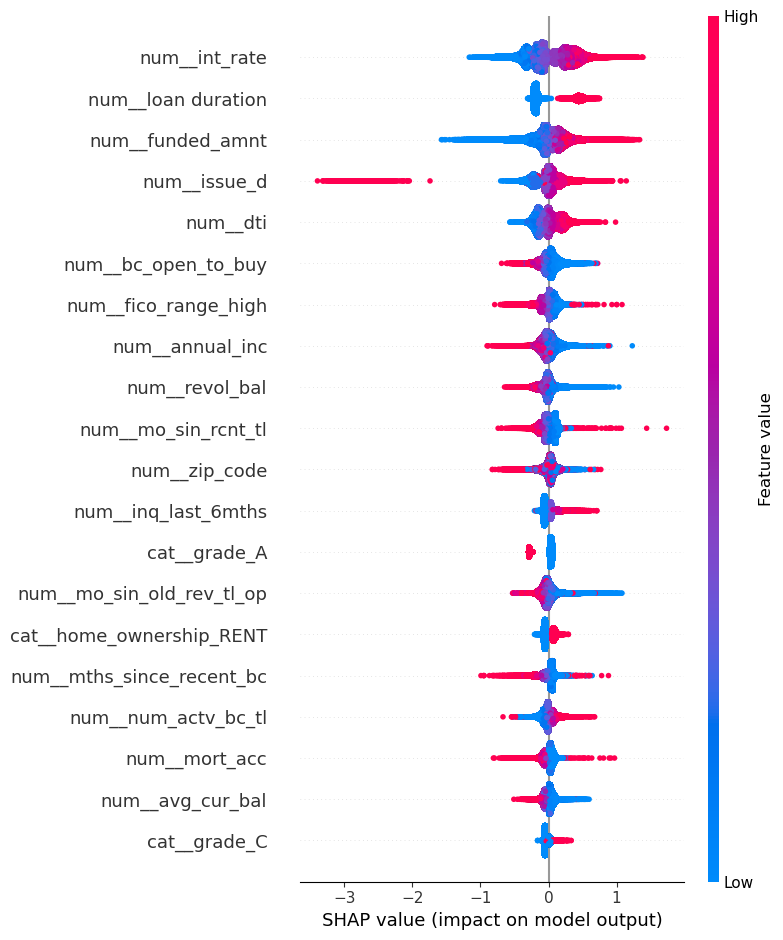

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Feature importance (mean |SHAP|)
feature_importance = np.abs(shap_values[:, :-1]).mean(axis=0)
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(8,5))
plt.barh([feature_names[i] for i in sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Mean |SHAP value|")
plt.title("SHAP Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# SHAP summary plot
shap.summary_plot(shap_values[:, :-1], X)


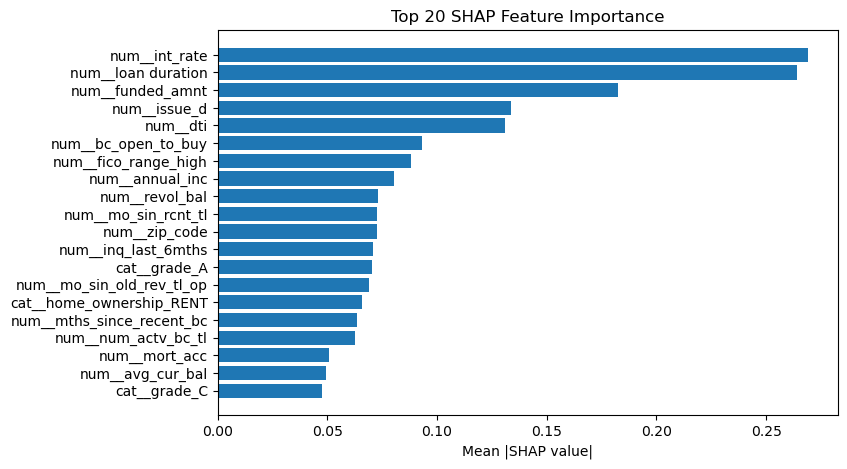

In [27]:
# Compute mean |SHAP| importance
feature_importance = np.abs(shap_values[:, :-1]).mean(axis=0)
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)[::-1]

# Keep only top 20
top_n = 20
top_idx = sorted_idx[:top_n]

plt.figure(figsize=(8, 5))
plt.barh([feature_names[i] for i in top_idx], feature_importance[top_idx])
plt.xlabel("Mean |SHAP value|")
plt.title(f"Top {top_n} SHAP Feature Importance")
plt.gca().invert_yaxis()
plt.show()